### Data Cleaning

In [ ]:
# !pip install pandas
# https://huggingface.co/oliverguhr/fullstop-punctuation-multilang-large
# !pip install deepmultilingualpunctuation protobuf
# !pip install nltk

In [ ]:
import pandas as pd
import re
import csv
from deepmultilingualpunctuation import PunctuationModel
import nltk
import matplotlib.pyplot as plt

### Data Cleaning

In [43]:
# INSIGHT_DATA_FILE = 'insight-transcripts-data.csv'
INSIGHT_DATA_FILE = 'insight-transcripts-data-cleaned.csv'
YOUTUBE_DATA_FILE = 'yt-transcripts-data.csv'

In [ ]:
model = PunctuationModel()

In [42]:
# Common intros to remove
PHRASES_TO_REMOVE = [
    r'.*welcome to carries conscious living are you ready to',
    r'.*on the 7th of this month are you ready to',
    r'.*are (you|we) ready to meditate (with|the)',
    r'.*join the patreon the links are in the description',
    r'.*if you are returning welcome back here at the',
    r".*I'm Sara Raymond here at the mindful movement",
    r'.*your host Brian Scott',
    r'.*create your free Mindvalley account today at mindvalley.com'
]

def data_clean(csv_file_path):
    cleaned_file_name = csv_file_path.rstrip('.csv')
    cleaned_file_name += '-cleaned.csv'

    df = pd.read_csv(csv_file_path, encoding='utf8')
    # df.dropna()

    with open(cleaned_file_name, 'a', encoding='utf8', newline='') as csvf:
        writer = csv.writer(csvf)
        # if csvf empty
        # writer.writerow(['Meditation_Type','URL','Script'])
        for idx, item in df.iterrows():
            s = item['Script']
            s = re.sub('\[.*?\]', ' ', s)  # Remove content inside square brackets
            s = re.sub('\(.*?\)', ' ', s)  # Remove contents inside square brackets
            s = re.sub('\s+',' ', s)  # Replace consecutive whitespace with a single space

            # Remove specific phrases  (FOR youtube data)
            s = re.sub('so( so)+', 'so', s)  # Remove consecutive 'so'
            s = re.sub('foreign( foreign)+', 'foreign', s)  # Remove consecutive 'foreign' 
            s = re.sub('you( you)+', 'you', s)  # Remove consecutive 'you'

            # Remove the unrelated introductions
            s = re.sub(".*let's (begin|start)", "let's start", s)
            s = re.sub(".*(begin|start) by", 'start by', s)
            for phrase in PHRASES_TO_REMOVE:
                s = re.sub(phrase, '', s)

            # Add Punctuation
            s = model.restore_punctuation(s)  # Takes very long time

            script = s
            url = item['URL']
            med_type = item['Meditation_Type']
            writer.writerow([med_type, url, script])
            print(f"Done Line {idx + 2}")  # Account for 0 index and the header line

    print(f'Written cleaned data to {cleaned_file_name}')

In [ ]:
data_clean(YOUTUBE_DATA_FILE)  # ADD -cleaned file??m

In [ ]:
data_clean(INSIGHT_DATA_FILE)

In [ ]:
# After adding punctuation, grep for lines that don't end with period

# Remove all instances of . you. and you" using find and replace (regex)
# Do the same with foreign  (also very common in youtube scripts)
# (youtube transcripts have a bunch of random you.)

#### Created new file `med-transcript-dataset.csv` with the insight timer data followed by the youtube data

### Add special tokens to dataset

In [ ]:
INPUT_DATA_FILE = 'med-transcript-dataset.csv'
TOKENIZED_DATA_FILE = 'tokenized-dataset.csv'

In [ ]:
import pandas as pd
import math
import csv

df = pd.read_csv(INPUT_DATA_FILE, encoding="utf8")  # encoding="ISO-8859-1"  Original
# df = df.dropna()  # DO NOT dropna() because insight timer rows have nan urls
# Empty file
with open(TOKENIZED_DATA_FILE, 'w') as f:
    f.truncate(0)

with open(TOKENIZED_DATA_FILE, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Meditation_Type','URL','Script'])
    for idx, item in df.iterrows():
        script = item['Script']
        url = item['URL']
        med_type = item['Meditation_Type']

        # ADD SPECIAL TOKEN indicating the meditation type
        if type(med_type)==str:
            special_token = f'[{med_type} MEDITATION]'.upper()
        # If nan values (type float), then don't add token
        else:
            special_token = ""

        script = f'{special_token} {script}'

        writer.writerow([med_type, url, script])

print(f"Written tokenized data file to {TOKENIZED_DATA_FILE}")

### Analyze Common Words

Analyze what the most common words to find phrases we should remove

In [ ]:
# Download the following nltk data if not done already
# nltk.download('punkt')
# nltk.download('stopwords')

In [64]:
import string
import pandas as pd

In [73]:
def get_freq_dist(csv_file_path):
    df = pd.read_csv(csv_file_path, encoding='utf8')
    script = ''
    # Only consider text from the Scripts
    for idx, item in df.iterrows():
        s = item['Script']
        script += s.lower()  # lower case everything
    print('Loaded text')

    text = ''
    # # Remove punctuation marks
    # for char in script:
    #     for j in list(string.punctuation):
    #         char = char.replace(j,'').lower()
    #     text += char
    # print('Removed punctuation marks')

    # Use to Stem text (reduce words to their base form)
    ps = nltk.stem.PorterStemmer()

    words = nltk.tokenize.word_tokenize(text)
    # all_word_dist = nltk.FreqDist(w.lower() for w in all_words)  # Frequency Distribution

    stopwords = nltk.corpus.stopwords.words('english')
    no_stopwords_dist = nltk.FreqDist(ps.stem(w) for w in words if w.isalpha() and w not in stopwords) # and w not in EXPECTED_WORDS)
    print('Got Frequency Distribution')
    return no_stopwords_dist

In [74]:
csv_file_path = 'med-transcript-dataset.csv'
no_stopwords_dist = get_freq_dist(csv_file_path)

Loaded text
Removed punctuation marks
Got Frequency Distribution


In [77]:
EXTRA_STOP_WORDS = ['like', 'come', 'one', 'know']

common_words_no_stops = no_stopwords_dist.most_common(30)#.keys()
common_words_no_stops = dict(common_words_no_stops)

# Remove common words that have no meaning
# final_common_words = 
print(common_words_no_stops)

{'feel': 57874, 'breath': 53324, 'bodi': 44165, 'go': 39566, 'let': 33774, 'mind': 30074, 'relax': 28185, 'love': 28117, 'take': 25821, 'back': 23814, 'life': 23319, 'right': 22191, 'time': 21745, 'like': 21073, 'energi': 20752, 'come': 20659, 'moment': 20163, 'one': 19708, 'know': 19581, 'allow': 18458, 'see': 18172, 'way': 18017, 'your': 16696, 'awar': 16086, 'notic': 15677, 'thought': 14813, 'need': 14556, 'get': 14487, 'thank': 14369, 'want': 14258}


<Axes: >

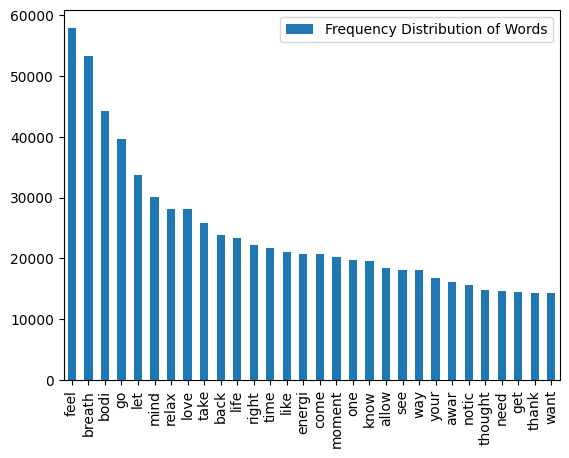

: 

In [78]:
# plot
df = pd.DataFrame(
    {'Frequency Distribution of Words':list(common_words_no_stops.values())},
    index=list(common_words_no_stops.keys())
)
df.plot(kind='bar')
# plt.hist(common_words_no_stops)
# plt.bar(common_words_no_stops.keys(), common_words_no_stops.values())

##### Let's see how much of each type of script we have

In [17]:
df = pd.read_csv('med-transcript-dataset.csv')
med_type_col = df['Meditation_Type']
med_type_col.value_counts()

Meditation_Type
visualization    1729
movement          964
body-scan         854
focused           839
reflection        310
Name: count, dtype: int64